# Phase space tomography

Primer for using phase space tomography tool

In [1]:
%load_ext autoreload
from preprocess import Preprocess
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tomo_plot import Plot
from reconstruct import Reconstruct
from track import Lattice, Model, Track
import utils


import pickle
plt.rcParams['image.cmap'] = 'jet'

Import sinograms measured in AWAKE. 

In [2]:

with open('my_sinox', 'rb') as f:
    data = pickle.load(f)

projectionsx = data['sinogram']
ksx = data['ks']

with open('my_sinoy', 'rb') as f:
    data = pickle.load(f)

projectionsy = data['sinogram']
ksy = data['ks']

# with open('input_data', 'rb') as f:
#     data = pickle.load(f)

# beam = data['beam']
# projectionsy = data['sino_y'].T
# projectionsx = data['sino_x'].T
# ksx = data['ksx']
# ksy = data['ksy'] 



Now it is time to preprocess the data to make them ready for tomography

In [45]:
%autoreload
sequence = {'quad':[0.0708,10], 'drift':[0.831693]}

processx = Preprocess(projectionsx, ksx, sequence, plane='x', norm=[1.8, 3.8])
processy = Preprocess(projectionsy, ksy, sequence, plane='y', norm=[1.8, 3.8])


the process instance is used as input for reconstruction

In [46]:
%autoreload
recx = Reconstruct(processx)
recy = Reconstruct(processy)

dist_x = recx.MLEM(300)
dist_y = recy.MLEM(300)

c:\Users\vbencini\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


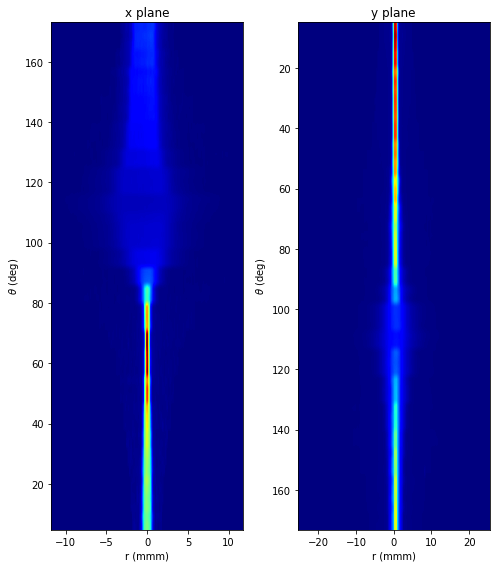

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>,
        <AxesSubplot:title={'center':'y plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>], dtype=object))

In [47]:
%autoreload
pl = Plot(processx, processy, dist_x, dist_y)
# Plot scaled sinograms

pl.plot_sino_scale()


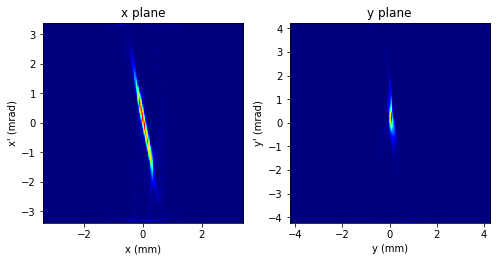

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='x (mm)', ylabel="x' (mrad)">,
        <AxesSubplot:title={'center':'y plane'}, xlabel='y (mm)', ylabel="y' (mrad)">], dtype=object))

In [48]:
pl.plot_reconstructed()

Let's generate a distribution from the reconstructed images

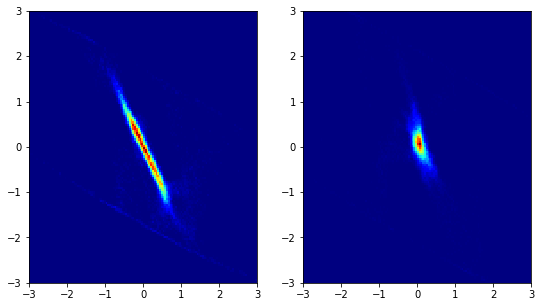

In [49]:
dist_x_part = utils.gen_dist(dist_x, 10000, processx.x_new)
dist_y_part = utils.gen_dist(dist_y, 10000, processy.x_new)

dist_x_part_unnorm = utils.apply(processx.Vi,dist_x_part)
dist_y_part_unnorm = utils.apply(processy.Vi,dist_y_part)

dist = np.hstack((dist_x_part_unnorm, dist_y_part_unnorm))

fig, axs = plt.subplots(1, 2, figsize= (9, 5))
_ = axs[0].hist2d(dist[:,0], dist[:,1], bins = 128, range=[[-3, 3],[-3, 3]])
_ = axs[1].hist2d(dist[:,2], dist[:,3], bins = 128, range=[[-3, 3],[-3, 3]])


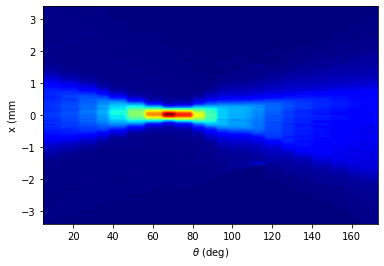

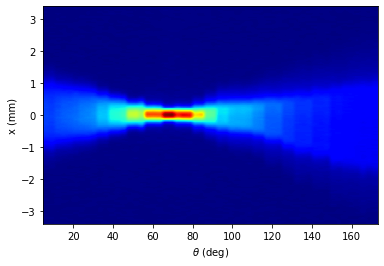

In [50]:
projections,_ = utils.track(dist_x_part_unnorm, processx.thetas, 'x', processx.x_new, processx.Vi, n_bins=128)
# projections,_ = utils.track(gen_d, processx.thetas, 'x', processx.x_new, processx.Vi, n_bins=128)
proj_trackx = utils.norm_image(projections)
plt.imshow(proj_trackx, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')
plt.savefig('proj_track_x.png', dpi=300)

plt.figure()
# plt.imshow(np.array(projections), origin = 'lower',extent=[thetas[0], thetas[-1], x[0], x[-1]],  aspect = 'auto', vmax=1)
plt.imshow(utils.norm_image(processx.unscaled_projections).T, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')
plt.savefig('proj_orig_x.png', dpi=300)

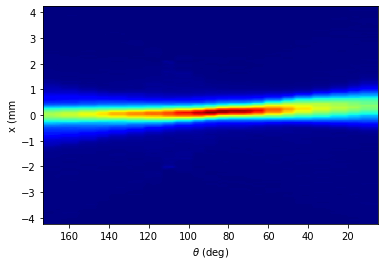

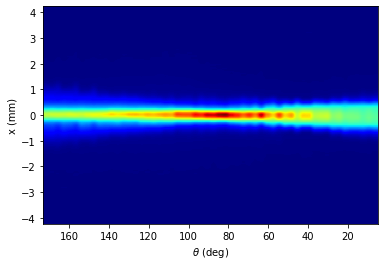

In [51]:
projections,_ = utils.track(dist_y_part_unnorm, processy.thetas, 'y', processy.x_new, processy.Vi, n_bins=128)
proj_tracky = utils.norm_image(projections)
plt.imshow(proj_tracky, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')
plt.savefig('proj_track_x.png', dpi=300)

plt.figure()
# plt.imshow(np.array(projections), origin = 'lower',extent=[thetas[0], thetas[-1], x[0], x[-1]],  aspect = 'auto', vmax=1)
plt.imshow(utils.norm_image(processy.unscaled_projections).T, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')
plt.savefig('proj_orig_x.png', dpi=300)

# Compare reconstruction methods

In [52]:
%autoreload
twiss_qs_x = recx.QuadScanRec()
twiss_qs_y = recy.QuadScanRec()

covx = twiss_qs_x[0]*np.array([[twiss_qs_x[2], -twiss_qs_x[1]],[-twiss_qs_x[1], twiss_qs_x[3]]])
covy = twiss_qs_y[0]*np.array([[twiss_qs_y[2], -twiss_qs_y[1]],[-twiss_qs_y[1], twiss_qs_y[3]]])
# Generate distribution with same Twiss parameters
dist_qs_x = np.random.multivariate_normal((0,0), covx, size=10000)
dist_qs_y = np.random.multivariate_normal((0,0), covy, size=10000)

dist_qs = np.hstack((dist_qs_x, dist_qs_y))
twiss_qs_y

<ipython-input-52-fba6b3538bb3>:8: RuntimeWarning: covariance is not positive-semidefinite.
  dist_qs_x = np.random.multivariate_normal((0,0), covx, size=10000)


(0.033422856734764583,
 0.82234044249173854,
 0.56211420210667096,
 2.9820342504696447)

In [53]:
%autoreload
# utils.get_twiss(dist_qs_x[:,0], dist_qs_x[:,1])
utils.get_twiss(dist_x_part_unnorm[:,0], dist_x_part_unnorm[:,1])

(0.29003934503230255,
 1.2188849954065086,
 1.0792923058460067,
 2.3030652757954351)

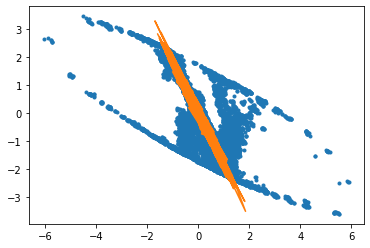

In [61]:
plt.plot(dist_x_part_unnorm[:,0], dist_x_part_unnorm[:,1],'.')
plt.plot(dist_qs_x[:,0], dist_qs_x[:,1])

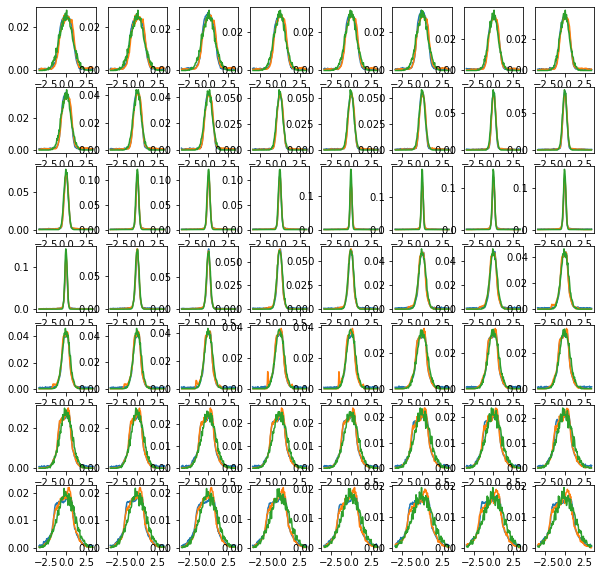

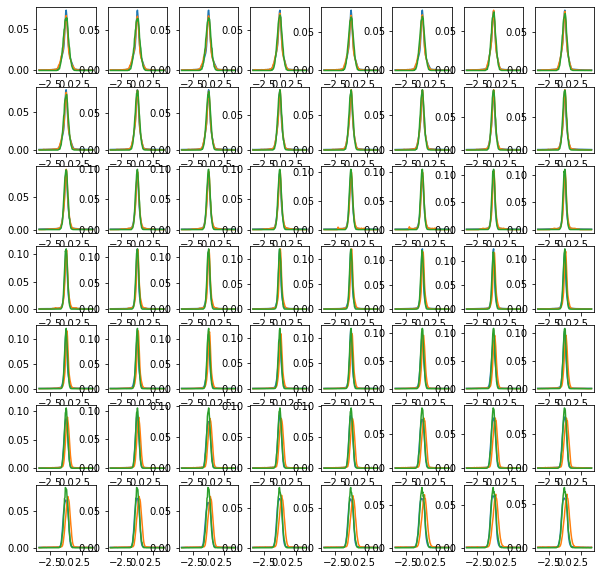

In [54]:
# ph = utils.get_theta_norm(Vi, k, 'x')
%autoreload
figx, axsx = plt.subplots(7,8, figsize = (10, 10))
figy, axsy = plt.subplots(7,8, figsize = (10, 10))
sigmasg_x = []
sigmasg_y = []
sigmas_rec_x = []
sigmas_rec_y = []
axsx = axsx.flatten()[:56]
axsy = axsy.flatten()[:56]

for p in range(56):
    ind = p
    seq = {'quad':[0.0708,recx.ks[ind]], 'drift':[0.831693]}
    tr = Track(seq, dist)
    tr.track()
    dist_out = tr.dist_out
    tr.dist = dist_qs
    tr.track()
    dist_qs_out = tr.dist_out

    projectionx, edgesx = np.histogram(dist_out[:,0], range=(processx.x_new[0], processx.x_new[-1]), bins=128)
    projectiongx, edgesgx = np.histogram(dist_qs_out[:,0], range=(processx.x_new[0], processx.x_new[-1]), bins=128)
    projectionx = projectionx/np.sum(projectionx)
    projectiongx = projectiongx/np.sum(projectiongx)

    projectiony, edgesy = np.histogram(dist_out[:,2], range=(processy.x_new[0], processy.x_new[-1]), bins=128)
    projectiongy, edgesgy = np.histogram(dist_qs_out[:,2], range=(processy.x_new[0], processy.x_new[-1]), bins=128)
    projectiony = projectiony/np.sum(projectiony)
    projectiongy = projectiongy/np.sum(projectiongy)

    axsx[p].plot(processx.x_new, processx.unscaled_projections[ind,:]/np.sum(processx.unscaled_projections[ind,:]))
    axsx[p].plot(utils.get_bin_centers(edgesx), projectionx)
    axsx[p].plot(utils.get_bin_centers(edgesgx), projectiongx)

    axsy[p].plot(processy.x_new, processy.unscaled_projections[ind,:]/np.sum(processy.unscaled_projections[ind,:]))
    axsy[p].plot(utils.get_bin_centers(edgesy), projectiony)
    axsy[p].plot(utils.get_bin_centers(edgesgy), projectiongy)

    coeffsx,_ = utils.gaussian_profile_fit(utils.get_bin_centers(edgesx), projectionx)
    sigmas_rec_x.append(coeffsx[2])
    sigmasg_x.append(np.std(dist_qs_out[:,0]))
    coeffsy,_ = utils.gaussian_profile_fit(utils.get_bin_centers(edgesy), projectiony)
    sigmas_rec_y.append(coeffsy[2])
    sigmasg_y.append(np.std(dist_qs_out[:,2]))


# figx.tight_layout()
# plt.plot(processx.x_new, processx.unscaled_projections[5,:])
# plt.plot(processx.x_new, processx.unscaled_projections[10,:])

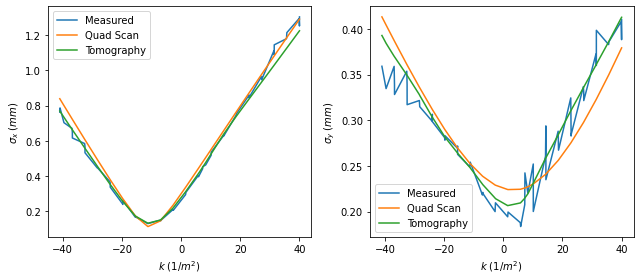

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
axs[0].plot(recx.ks, recx.sigmas, label = 'Measured')
axs[0].plot(recx.ks, np.array(sigmasg_x), label='Quad Scan')
axs[0].plot(recx.ks, np.array(sigmas_rec_x), label='Tomography')
axs[0].set_xlabel('$k$ $(1/m^2)$')
axs[0].set_ylabel('$\sigma_x$ $(mm)$')
axs[1].plot(recx.ks, recy.sigmas, label = 'Measured')
axs[1].plot(recx.ks, np.array(sigmasg_y), label='Quad Scan')
axs[1].plot(recx.ks, np.array(sigmas_rec_y), label='Tomography')
axs[1].set_xlabel('$k$ $(1/m^2)$')
axs[1].set_ylabel('$\sigma_y$ $(mm)$')
axs[0].legend()
axs[1].legend()
plt.tight_layout()

# Neural Network

To use the LSTM enhanced model, we need first to interpolate the sinograms to have 5 degrees steps.

In [56]:
from scipy.interpolate import RegularGridInterpolator

x, y = processx.x_new, processx.thetas
xg, yg = np.meshgrid(x,y, indexing='ij')
data = processx.projections.T
interp = RegularGridInterpolator((x, y), data,
                                 bounds_error=False, fill_value=None)
x_n, y_n = np.linspace(x.min(), x.max(), 64), np.arange(y.min(), y.max())
X, Y = np.meshgrid(x_n, y_n, indexing='ij')
new_proj = interp((X,Y))

In [58]:
missing_angles_range = 180-(y.max()-y.min())
missing_angles = np.floor(missing_angles_range/5)
missing_angles

2.0

In [43]:
# a_r = np.arange(-2,2, 0.2)
# b_r = np.arange(0,5, 0.2)
# delta = 0
# for a, b in zip(a_r, b_r):
#     processTest = Preprocess(projectionsy, ksy, sequence, plane='y', norm=[a, b])
#     temp = processTest.thetas.max()-processTest.thetas.min()
#     if temp>delta:
#         delta =  temp
#         a_opt = a
#         b_opt = b



c:\Users\vbencini\cernbox\AWAKE\Run2b\18MeV-eline\phase_space_tomography\utils.py:498: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([[1/np.sqrt(beta), 0], [alpha/np.sqrt(beta), np.sqrt(beta)]])
c:\Users\vbencini\cernbox\AWAKE\Run2b\18MeV-eline\phase_space_tomography\utils.py:502: RuntimeWarning: divide by zero encountered in double_scalars
  return np.linalg.inv(np.array([[1/np.sqrt(beta), 0], [alpha/np.sqrt(beta), np.sqrt(beta)]]))
